# Descripción del sistema
El sistema consiste en el desarrollo de 5 gráficos diferentes, estos gráficos son realizados con dos conjuntos de datos de dos entidades costarricenses diferentes que son el INEC y el OIJ, ambos conjuntos de datos fueron descargados en formato csv y son almacenados como dataframes utilizando la función de spark en python, además de estos los datos son limpiados ya que tienen incongruencias en su formato, una vez con los datos limpios se envían los mismo a postgres y se grafican

In [1]:
#Bibliotecas necesarias para el uso de spark
from pyspark.sql import SparkSession
from pyspark.files import SparkFiles
from pyspark.sql import functions as F
from pyspark.sql.functions import col, unix_timestamp, to_date , regexp_replace
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas

In [2]:
#Se guardan ambos archivos como dataframes
oij_csv=spark.read.format("csv").option("header","true").option("inferSchema","true").load("Estadisticas.csv")
inec_csv=spark.read.format("csv").option("header","true").option("inferSchema","true").load("reempleocenso2011-22.csv")

In [3]:
#Se imprimen ambos esquemas para observar el formato en el que vienen los datos, esto servirá para ajustar
#el dataframe a lo que necesitemos
#este de abajo será el formato del OIJ
oij_csv.printSchema()
oij_csv.show()

root
 |-- Delito: string (nullable = true)
 |-- SubDelito: string (nullable = true)
 |-- Fecha: string (nullable = true)
 |-- Hora: string (nullable = true)
 |-- Victima: string (nullable = true)
 |-- SubVictima: string (nullable = true)
 |-- Edad: string (nullable = true)
 |-- Genero: string (nullable = true)
 |-- Nacionalidad: string (nullable = true)
 |-- Provincia: string (nullable = true)
 |-- Canton: string (nullable = true)
 |-- Distrito: string (nullable = true)

+------+-----------+----------+-------------------+-----------+--------------------+-------------+------+------------+----------+------------+-------------+
|Delito|  SubDelito|     Fecha|               Hora|    Victima|          SubVictima|         Edad|Genero|Nacionalidad| Provincia|      Canton|     Distrito|
+------+-----------+----------+-------------------+-----------+--------------------+-------------+------+------------+----------+------------+-------------+
|ASALTO|ARMA BLANCA|2011-01-10|15:00:00 - 17:59:59|  

In [4]:
#Este otro formato correspone al INEC
inec_csv=inec_csv.withColumn('PoblacionMayor15', regexp_replace(col('PoblacionMayor15'), " ", ""))
inec_csv=inec_csv.withColumn('PoblacionMayor15',inec_csv['PoblacionMayor15'].cast("Integer").alias('PoblacionMayor15'))
inec_csv=inec_csv.withColumn('TasaDesempleoAbierto',inec_csv['TasaDesempleoAbierto'].cast("double").alias('TasaDesempleoAbierto'))
inec_csv.printSchema()

root
 |-- ProvinciaCantonDistrito: string (nullable = true)
 |-- PoblacionMayor15: integer (nullable = true)
 |-- TasaNetaParticipacion: double (nullable = true)
 |-- TasaOcupacion: double (nullable = true)
 |-- TasaDesempleoAbierto: double (nullable = true)
 |-- PorcentajeEconomicamenteInactivo: double (nullable = true)
 |-- RelacionDependenciaEconomica: double (nullable = true)



In [5]:
#Se registran ambos dataframe como tablas de SQL, esto nos permite realizar consultas sql por medio de sqlContext

sqlContext.registerDataFrameAsTable(oij_csv, "oij")
sqlContext.registerDataFrameAsTable(inec_csv, "inec_csv")
#Se arregla el archivo del inec original para poder juntarlo correctamente
inec_csv1= sqlContext.sql("SELECT ProvinciaCantonDistrito, SUM(PoblacionMayor15) PoblacionMayor15, AVG(TasaNetaParticipacion)TasaNetaParticipacion,AVG(TasaOcupacion)TasaOcupacion,AVG(TasaDesempleoAbierto)TasaDesempleoAbierto,AVG(PorcentajeEconomicamenteInactivo)PorcentajeEconomicamenteInactivo, AVG(RelacionDependenciaEconomica)RelacionDependenciaEconomica FROM inec_csv GROUP BY ProvinciaCantonDistrito ")
sqlContext.registerDataFrameAsTable(inec_csv1, "inec")

In [6]:
'''
Entradas: Un entero
Salidas: Un dataframe
Descripción general: Se encarga de validar cual conjunto de datos se debe enviar 
y realiza la consulta SQL correspondiente la cual removerá espacios en blanco
'''
def quitaEspacios(ind):
    #Este if es de validación para enviar datos de INEC o del OIJ
    #por medio de sqlContext se utiliza la función TRIM que acorta todos los espacios en blanco
    #almacenados antes o después de nuestros datos
    if ind == 1:
        return sqlContext.sql("SELECT Delito, SubDelito,Hora, Fecha, Victima, SubVictima, Edad, Genero, Nacionalidad, Provincia,Canton, TRIM(Distrito) as Distrito from oij")
    else:
        return sqlContext.sql("SELECT TRIM(ProvinciaCantonDistrito) AS ProvinciaCantonDistrito, PoblacionMayor15, TasaNetaParticipacion, TasaOcupacion, TasaDesempleoAbierto, PorcentajeEconomicamenteInactivo, RelacionDependenciaEconomica from inec")

In [7]:
#Simplemente se llama a la función con el número entero correspondiente y se registra el nuevo dataframe
#como la tabla almacenada anteriormente en el sistema, esto se aplica para ambos conjuntos de datos
oij = quitaEspacios(1)
sqlContext.registerDataFrameAsTable(oij, "oij")
inec = quitaEspacios(2)
sqlContext.registerDataFrameAsTable(inec, "inec")

In [8]:
'''
Entradas: Un entero
Salidas: Un dataframe
Descripción general: Se encarga de validar cual conjunto de datos se debe enviar 
y realiza la consulta SQL correspondiente la cual pasará los datos a minúscula
'''
def minusculas(ind):
    #Este if es de validación para enviar datos de INEC o del OIJ
    #por medio de sqlContext se utiliza la función LOWER que se encarga de pasar los datos a minúscula
    if ind == 1:
        return sqlContext.sql("SELECT Delito, SubDelito,Hora, Fecha, Victima, SubVictima, Edad, Genero, Nacionalidad, Provincia,Canton, LOWER(Distrito) as Distrito from oij")
    else:
        return sqlContext.sql("SELECT LOWER(ProvinciaCantonDistrito) AS ProvinciaCantonDistrito, PoblacionMayor15, TasaNetaParticipacion, TasaOcupacion, TasaDesempleoAbierto, PorcentajeEconomicamenteInactivo, RelacionDependenciaEconomica from inec")

In [9]:
#Se llama a la función con el número entero correspondiente y se registra el nuevo dataframe
#como la tabla almacenada anteriormente en el sistema, se aplica a ambos conjuntos de datos
oij = minusculas(1)
sqlContext.registerDataFrameAsTable(oij, "oij")
inec = minusculas(2)
sqlContext.registerDataFrameAsTable(inec, "inec")

In [10]:
'''
Entradas: No posee
Salidas: Un dataframe
Descripción general: Se encarga de hacer la consulta sql para mostrar los datos del OIJ
que no coinciden con ningún dato del INEC
'''
def sacaNoExistentes():
    #Esta consulta se encarga de sacar los distintos por medio del uso de DISTINCT que no se encuentren
    #en la consulta realizada a los datos del INEC
    return sqlContext.sql("SELECT DISTINCT(Distrito) FROM oij WHERE NOT EXISTS(SELECT 1 FROM inec WHERE inec.ProvinciaCantonDistrito = oij.Distrito)") 

In [11]:
#Llama a la función y lo almacena como un dataframe nuevo y una tabla nueva
noCoinciden = sacaNoExistentes()
sqlContext.registerDataFrameAsTable(noCoinciden, "noCoincidencias")

In [12]:
#Se muestran los datos que no coincidieron, principalmente fue porque el OIJ utiliza abreviaciones y no usa tildes,
#el INEC no
noCoinciden.show()

+-----------------+
|         Distrito|
+-----------------+
|       rio cuarto|
|     san jeronimo|
|           libano|
|             para|
|            colon|
|         guapiles|
|          guacimo|
|           puraba|
|            cajon|
|            belen|
|belen de nosarita|
|           granja|
|      santa lucia|
|      desconocido|
|      santo tomas|
|           jardin|
|       agua buena|
|         tarcoles|
|          alegria|
|      santa maria|
+-----------------+
only showing top 20 rows



In [13]:
'''
Entradas: No posee
Salidas: Un dataframe
Descripción general: Se encarga de contar los elementos de la tabla de noCoincidencias
estos elementos corresponen a todos aquellos distritos del OIJ que no corresponden a distritos del INEC
'''
def cuentaNoExistentes():
    return sqlContext.sql("SELECT COUNT(*) as num FROM noCoincidencias") 

In [14]:
#Almacena el dataframe con el dato
numNoCoinciden = cuentaNoExistentes()

In [15]:
#Se despliega el número correspondiente
numNoCoinciden.show()
print("Cantidad de registros que no coincidieron: ", noCoinciden.count())

+---+
|num|
+---+
|102|
+---+

Cantidad de registros que no coincidieron:  102


In [16]:
#Se modifican datos del dataframe del INEC para que correspondan a algunos datos del OIJ
#esto se encarga de buscar por columna los datos que tengan almaceanado los nombres de la manera indicada
#luego se modifican por sus correpondientes en el dataframe del OIJ
inec = inec.withColumn("ProvinciaCantonDistrito", F.when(F.col("ProvinciaCantonDistrito")=='pococí','pococi').otherwise(F.col("ProvinciaCantonDistrito")))
inec = inec.withColumn("ProvinciaCantonDistrito", F.when(F.col("ProvinciaCantonDistrito")=='la unión','la union').otherwise(F.col("ProvinciaCantonDistrito")))
inec = inec.withColumn("ProvinciaCantonDistrito", F.when(F.col("ProvinciaCantonDistrito")=='belén','belen').otherwise(F.col("ProvinciaCantonDistrito")))
inec = inec.withColumn("ProvinciaCantonDistrito", F.when(F.col("ProvinciaCantonDistrito")=='león cortés castro','leon cortes').otherwise(F.col("ProvinciaCantonDistrito")))
inec = inec.withColumn("ProvinciaCantonDistrito", F.when(F.col("ProvinciaCantonDistrito")=='san josé','san jose').otherwise(F.col("ProvinciaCantonDistrito")))
#se guarda el dataframe modificado como una tabla
sqlContext.registerDataFrameAsTable(inec, "inec")

In [17]:
#Se integran por medio de un inner join los conjuntos de datos,y se almacenan como un nuevo dataframe
#este dataframe será enviado a postgres
datosIntegrados = sqlContext.sql("SELECT a.Delito, a.SubDelito, a.Hora, a.Fecha, a.Victima, a.SubVictima, a.Edad, a.Genero, a.Nacionalidad, a.Provincia, a.Canton, a.Distrito, b.PoblacionMayor15, b.TasaNetaParticipacion, b.TasaOcupacion, b.TasaDesempleoAbierto, b.PorcentajeEconomicamenteInactivo, b.RelacionDependenciaEconomica FROM oij a INNER JOIN inec b ON a.Distrito = b.ProvinciaCantonDistrito")

In [18]:
datosIntegrados.printSchema()

root
 |-- Delito: string (nullable = true)
 |-- SubDelito: string (nullable = true)
 |-- Hora: string (nullable = true)
 |-- Fecha: string (nullable = true)
 |-- Victima: string (nullable = true)
 |-- SubVictima: string (nullable = true)
 |-- Edad: string (nullable = true)
 |-- Genero: string (nullable = true)
 |-- Nacionalidad: string (nullable = true)
 |-- Provincia: string (nullable = true)
 |-- Canton: string (nullable = true)
 |-- Distrito: string (nullable = true)
 |-- PoblacionMayor15: long (nullable = true)
 |-- TasaNetaParticipacion: double (nullable = true)
 |-- TasaOcupacion: double (nullable = true)
 |-- TasaDesempleoAbierto: double (nullable = true)
 |-- PorcentajeEconomicamenteInactivo: double (nullable = true)
 |-- RelacionDependenciaEconomica: double (nullable = true)



In [19]:
#Se realiza un cast para poder convertir los datos de string a los que originalmente pertenecen
datosIntegrados=datosIntegrados.withColumn('TasaDesempleoAbierto',datosIntegrados['TasaDesempleoAbierto'].cast("float").alias('TasaDesempleoAbierto'))
datosIntegrados=datosIntegrados.withColumn('TasaNetaParticipacion',datosIntegrados['TasaNetaParticipacion'].cast("float").alias('TasaNetaParticipacion'))
datosIntegrados=datosIntegrados.withColumn('TasaOcupacion',datosIntegrados['TasaOcupacion'].cast("float").alias('TasaOcupacion'))
datosIntegrados=datosIntegrados.withColumn('PorcentajeEconomicamenteInactivo',datosIntegrados['PorcentajeEconomicamenteInactivo'].cast("float").alias('PorcentajeEconomicamenteInactivo'))
datosIntegrados=datosIntegrados.withColumn('RelacionDependenciaEconomica',datosIntegrados['RelacionDependenciaEconomica'].cast("float").alias('RelacionDependenciaEconomica'))
datosIntegrados=datosIntegrados.withColumn('Fecha',to_date(unix_timestamp(col('Fecha'), 'yyyy-MM-dd').cast("timestamp")))

In [20]:
#Se imprime los datos para observar el cambio correctamente
datosIntegrados.printSchema()

root
 |-- Delito: string (nullable = true)
 |-- SubDelito: string (nullable = true)
 |-- Hora: string (nullable = true)
 |-- Fecha: date (nullable = true)
 |-- Victima: string (nullable = true)
 |-- SubVictima: string (nullable = true)
 |-- Edad: string (nullable = true)
 |-- Genero: string (nullable = true)
 |-- Nacionalidad: string (nullable = true)
 |-- Provincia: string (nullable = true)
 |-- Canton: string (nullable = true)
 |-- Distrito: string (nullable = true)
 |-- PoblacionMayor15: long (nullable = true)
 |-- TasaNetaParticipacion: float (nullable = true)
 |-- TasaOcupacion: float (nullable = true)
 |-- TasaDesempleoAbierto: float (nullable = true)
 |-- PorcentajeEconomicamenteInactivo: float (nullable = true)
 |-- RelacionDependenciaEconomica: float (nullable = true)



In [21]:
#Se revisa que el cast que se hizo anteriormente no alterara registros
datosIntegrados.show()

+------+-----------+-------------------+----------+-----------+--------------------+-------------+------+------------+----------+-------------+-------------+----------------+---------------------+-------------+--------------------+--------------------------------+----------------------------+
|Delito|  SubDelito|               Hora|     Fecha|    Victima|          SubVictima|         Edad|Genero|Nacionalidad| Provincia|       Canton|     Distrito|PoblacionMayor15|TasaNetaParticipacion|TasaOcupacion|TasaDesempleoAbierto|PorcentajeEconomicamenteInactivo|RelacionDependenciaEconomica|
+------+-----------+-------------------+----------+-----------+--------------------+-------------+------+------------+----------+-------------+-------------+----------------+---------------------+-------------+--------------------+--------------------------------+----------------------------+
|ASALTO|ARMA BLANCA|15:00:00 - 17:59:59|2011-01-10|    PERSONA|MENOR DE EDAD [PE...|Menor de edad|HOMBRE|  COSTA RICA|

In [22]:
#Se crea una sesión para que spark pueda acceder correctamente a postgres
spark = SparkSession \
    .builder \
    .appName("Basic JDBC pipeline") \
    .config("spark.driver.extraClassPath", "postgresql-42.1.4.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.1.4.jar") \
    .getOrCreate()

In [23]:
'''
Entradas: Un dataframe y un string
Salidas: No tiene
Descripción general: Se encarga de que por medio de la sesión anteriormente abierta 
spark pueda acceder correctamente a la sesión de postgres y seguidamente replicar el
dataframe enviado como una tabla propia del postgres
'''
def mandaPostgres(dataframe, nombre):
    dataframe \
        .write \
        .format("jdbc") \
        .mode('overwrite') \
        .option("url", "jdbc:postgresql://localhost/") \
        .option("user", "postgres") \
        .option("password", "password") \
        .option("dbtable", nombre) \
        .save()

In [24]:
#Se ejecuta la función mandaPostgres para cargar los registros de la tabla datosIntegrados
mandaPostgres(datosIntegrados.select("Delito","SubDelito","Hora","Fecha","Victima","SubVictima","Edad","Genero","Nacionalidad","Provincia","Canton","Distrito","PoblacionMayor15","TasaNetaParticipacion","TasaOcupacion","TasaDesempleoAbierto","PorcentajeEconomicamenteInactivo","RelacionDependenciaEconomica"),"prueba")


# Visualizaciones en Spark

## 1. Cantidad de delitos y la tasa de ocupación para los 10 distritos con más delitos

A continuación se mostrará una comparativa entre los delitos y la tasa de ocupación entre los 10 distritos con más delitos en la cuál se ordenara de mayor a menor la cantidad de delitos para poder determinar el distrito con más delitos y su tasa de ocupación en el año 2011 según el INEC junto al OIJ..
    

In [25]:
#Se crea un dataframe de datosIntegrados para poder realizar consultas en dicha tabla
sqlContext.registerDataFrameAsTable(datosIntegrados,"datosIntegrados")

'''
Entradas: No tiene
Salidas: Un dataframe
Descripción general: Se encarga de realizar una consulta la cual retorna un
dataframe comparando la cantidad de delitos y la tasa de ocupación com más delitos en el país.
'''
def top10Distritos():
    return sqlContext.sql("SELECT DISTINCT distrito, COUNT(delito) as Cantidad_Delitos, SUM(tasaocupacion)/COUNT(delito) as Tasa_Ocupacion FROM datosIntegrados group by distrito order by 2 DESC LIMIT 10") 
#Se envia la función a una variables
top10Distritos=top10Distritos()
#Seguidamente se muestra el dataframe obtenido
top10Distritos.show()

+----------+----------------+------------------+
|  distrito|Cantidad_Delitos|    Tasa_Ocupacion|
+----------+----------------+------------------+
|    carmen|            1346| 53.44999885559082|
|san rafael|            1262| 52.58333206176758|
|   liberia|            1108|50.099998474121094|
|  hospital|            1079|53.900001525878906|
|  catedral|            1073|              57.0|
| san pedro|            1011|  49.9571418762207|
|  alajuela|             990|53.400001525878906|
|     uruca|             984|57.349998474121094|
|    quepos|             857|              54.0|
|    merced|             850|              57.0|
+----------+----------------+------------------+



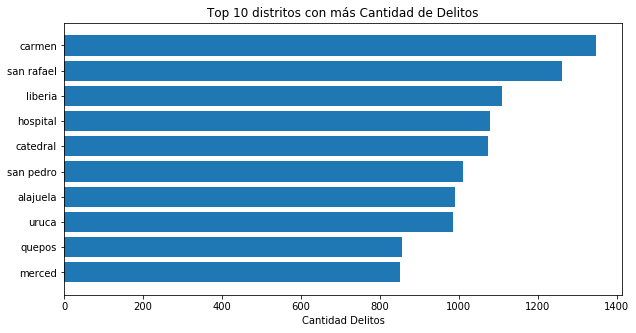

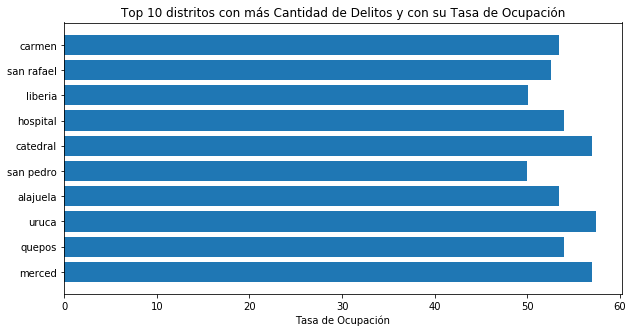

<Figure size 2160x2160 with 0 Axes>

In [55]:
#Separa los registros del dataframe anterior a listas para poder graficar y se procede a graficar
y= top10Distritos.toPandas() ["distrito"].values.tolist()
x= top10Distritos.toPandas() ["Cantidad_Delitos"].values.tolist()
z= top10Distritos.toPandas() ["Tasa_Ocupacion"].values.tolist()

#Se crea la figura de la gráfica
fig1, ax1 = plt.subplots()
#Obtenemos una lista con las posiciones
y_pos = np.arange(len(y))
#Creamos la grafica pasando los valores en el eje X, Y
plt.barh(y_pos[::-1], x, align='center', alpha=1)
#Añadimos la etiqueta de nombre de cada distrito
plt.yticks(y_pos, y[::-1])
#añadimos una etiqueta en el eje X
plt.xlabel('Cantidad Delitos')
#Se reajusta las gráficas para leerlas correctamente
fig1.set_size_inches(10, 5)
#Y una etiqueta superior
plt.title('Top 10 distritos con más Cantidad de Delitos')
plt.show()

#Se crea la figura de la gráfica
fig2, ax2 = plt.subplots()
#Obtenemos una lista con las posiciones
y_pos = np.arange(len(y))
#Creamos la grafica pasando los valores en el eje X, Y
plt.barh(y_pos[::-1], z, align='center', alpha=1)
#Añadimos la etiqueta de nombre de cada distrito
plt.yticks(y_pos, y[::-1])
#añadimos una etiqueta en el eje X
plt.xlabel('Tasa de Ocupación')
#Se reajusta las gráficas para leerlas correctamente
fig2.set_size_inches(10, 5)
#Y una etiqueta superior
plt.title('Top 10 distritos con más Cantidad de Delitos y con su Tasa de Ocupación')
plt.figure(figsize=(30,30))
plt.show()


## 2. Cantidad de delitos por día de la semana para el distrito con más delitos

Seguidamente se presentará la comparativa con respecto a los delitos del cantón con más delitos en cada día de la semana, así se visualizará que día hubo mayor auge de delitos y que día no hubo menos delitos en el año 2011 según el INEC junto al OIJ.

In [27]:
'''
Entradas: No tiene
Salidas: Un dataframe
Descripción general: Se encarga de realizar una consulta la cual retorna un
dataframe comparando la cantidad de delitos y con los días de la semana en con respecto
al distrito con más delitos.
'''
def delitosDia():
    return sqlContext.sql("SELECT distrito,COUNT(delito) as Cantidad_Delitos, date_format(Fecha, 'EEEE') as Dia_Semana FROM datosIntegrados WHERE distrito='carmen' group by distrito,Dia_Semana") 
#Se envia la función a una variables
delitosDia=delitosDia()
#Seguidamente se muestra el dataframe obtenido
delitosDia.show()

+--------+----------------+----------+
|distrito|Cantidad_Delitos|Dia_Semana|
+--------+----------------+----------+
|  carmen|             170|  Thursday|
|  carmen|             176|    Sunday|
|  carmen|             180| Wednesday|
|  carmen|             168|   Tuesday|
|  carmen|             200|    Monday|
|  carmen|             210|    Friday|
|  carmen|             242|  Saturday|
+--------+----------------+----------+



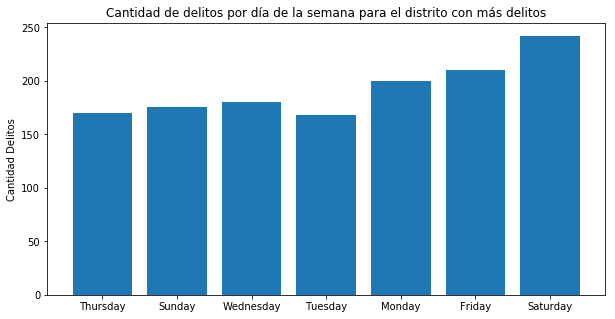

In [44]:
#Separa los registros del dataframe anterior a listas para poder graficar y se procede a graficar
x=delitosDia.toPandas() ["Dia_Semana"].values.tolist()

y= delitosDia.toPandas() ["Cantidad_Delitos"].values.tolist()
#Se crea la figura de la gráfica
fig, ax = plt.subplots()
#Colocamos una etiqueta en el eje Y
ax.set_ylabel('Cantidad Delitos')
#Colocamos una etiqueta en el eje X
ax.set_title('Cantidad de delitos por día de la semana para el distrito con más delitos')
#Creamos la grafica de barras utilizando x,y
plt.bar(x, y)
#Se reajusta las gráficas para leerlas correctamente
fig.set_size_inches(10, 5)
#Finalmente mostramos la grafica con el metodo show()
plt.show()

## 3. Cantidad de delitos por tipo y por distrito

En la siguiente gráfica se mostrarán la cantidad de delitos por tipo del distrito seleccionado, en este caso se seleccionó el distrito con más delitos el cual corresponde a el distrito del "carmen" en el año 2011 según el INEC junto al OIJ.

In [29]:
'''
Entradas: No tiene
Salidas: Un dataframe
Descripción general: Se encarga de realizar una consulta la cual retorna un
dataframe comparando la cantidad de delitos con el tipo correspondiente, seleccionando el
distrito que se quiera, en este caso se seleccionó el distrito del "carmen".
'''
def delitosTipo():
    return sqlContext.sql("SELECT distrito,COUNT(delito) as Cantidad_Delitos, delito as Tipo_Delito FROM datosIntegrados WHERE distrito='carmen' group by distrito,delito ") 
#Se envia la función a una variables
delitosTipo=delitosTipo()
#Seguidamente se muestra el dataframe obtenido
delitosTipo.show()

+--------+----------------+-----------------+
|distrito|Cantidad_Delitos|      Tipo_Delito|
+--------+----------------+-----------------+
|  carmen|             528|            HURTO|
|  carmen|              84| ROBO DE VEHICULO|
|  carmen|             514|           ASALTO|
|  carmen|             134|             ROBO|
|  carmen|              86|TACHA DE VEHICULO|
+--------+----------------+-----------------+



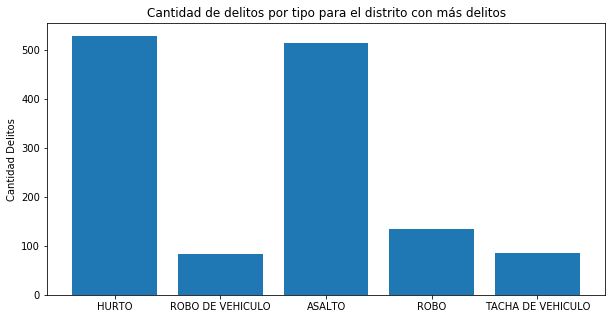

In [45]:
#Separa los registros del dataframe anterior a listas para poder graficar y se procede a graficar
x=delitosTipo.toPandas() ["Tipo_Delito"].values.tolist()

y= delitosTipo.toPandas() ["Cantidad_Delitos"].values.tolist()
 
fig, ax = plt.subplots()
#Colocamos una etiqueta en el eje Y
ax.set_ylabel('Cantidad Delitos')
#Colocamos una etiqueta en el eje X
ax.set_title('Cantidad de delitos por tipo para el distrito con más delitos')
#Creamos la grafica de barras utilizando x,y
plt.bar(x, y)
#Se reajusta las gráficas para leerlas correctamente
fig.set_size_inches(10, 5)
#Finalmente mostramos la grafica con el metodo show()
plt.show()

## 4. Cantidad de delitos por sexo para todo el conjunto de datos

Seguidamente se mostrará la cantidad de delitos por sexo que hay alrededor de toda la cantidad de datos al unir las tablas del INEC con el del OIJ, para saber que sexo es el que comete más delitos en el año 2011 según el INEC junto al OIJ.

In [31]:
'''
Entradas: No tiene
Salidas: Un dataframe
Descripción general: Se encarga de realizar una consulta la cual retorna un
dataframe comparando la cantidad de delitos con respecto al sexo de todos los datos.
'''
def delitosSexo():
    return sqlContext.sql("SELECT genero, COUNT(delito) as Cantidad_Delitos FROM datosIntegrados group by genero order by Cantidad_Delitos DESC") 
#Se envia la función a una variables
delitosSexo=delitosSexo()
#Seguidamente se muestra el dataframe obtenido
delitosSexo.show()

+-----------+----------------+
|     genero|Cantidad_Delitos|
+-----------+----------------+
|     HOMBRE|           26978|
|      MUJER|           11103|
|DESCONOCIDO|             194|
+-----------+----------------+



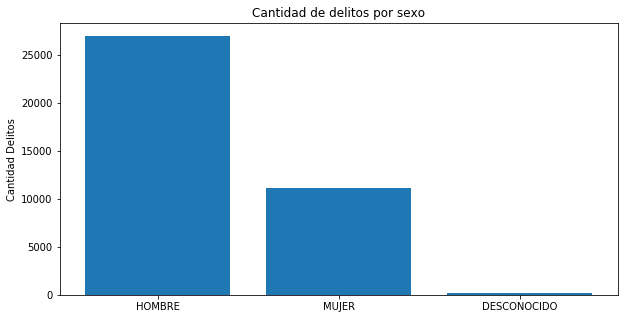

In [51]:
#Separa los registros del dataframe anterior a listas para poder graficar y se procede a graficar
x=delitosSexo.toPandas() ["genero"].values.tolist()

y= delitosSexo.toPandas() ["Cantidad_Delitos"].values.tolist()
 
fig, ax = plt.subplots()
#Colocamos una etiqueta en el eje Y
ax.set_ylabel('Cantidad Delitos')
#Colocamos una etiqueta en el eje X
ax.set_title('Cantidad de delitos por sexo')
#Creamos la grafica de barras utilizando x,y
plt.bar(x, y)
#Se reajusta las gráficas para leerlas correctamente
fig.set_size_inches(10, 5)
#Finalmente mostramos la grafica con el metodo show()
plt.show()

## 5. Cantidad de delitos con respecto a su subdelito de los 10 distritos con más delitos

Finalmente se mostrará la cantidad de delitos con su respectivo subdelito de los 10 distritos con más delitos del pais en el año 2011.

In [33]:
'''
Entradas: No tiene
Salidas: Un dataframe
Descripción general: Se encarga de realizar una consulta la cual retorna un
dataframe comparando la cantidad de delitos con su respectivo subdelito de los 10 distritos
con más delitos.
'''
def subdelitosCant():
    return sqlContext.sql("SELECT Subdelito, COUNT(delito) as Cantidad_Delitos FROM datosIntegrados group by Subdelito ORDER BY Cantidad_Delitos DESC limit 10") 
#Se envia la función a una variables
subdelitosCant=subdelitosCant()
#Seguidamente se muestra el dataframe obtenido
subdelitosCant.show()

+-----------------+----------------+
|        Subdelito|Cantidad_Delitos|
+-----------------+----------------+
|    ARMA DE FUEGO|            6132|
|        FORZADURA|            5897|
|     POR DESCUIDO|            4974|
|TACHA DE VEHICULO|            3534|
|         DESCUIDO|            2325|
|      ARMA BLANCA|            2229|
|    POR CONFIANZA|            2043|
|         ARREBATO|            1111|
|          BOQUETE|            1044|
|  QUITAN CELOSIAS|             957|
+-----------------+----------------+



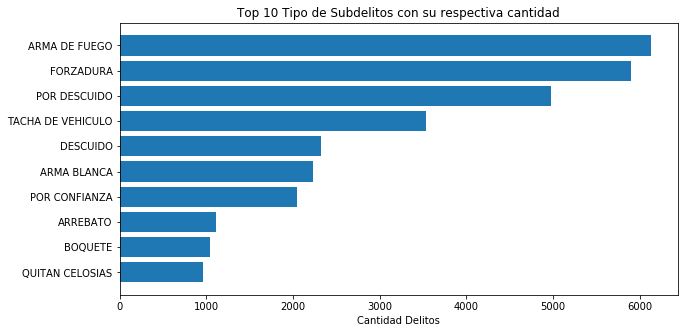

In [53]:
#Separa los registros del dataframe anterior a listas para poder graficar y se procede a graficar
y=subdelitosCant.toPandas() ["Subdelito"].values.tolist()

x= subdelitosCant.toPandas() ["Cantidad_Delitos"].values.tolist()

#Se crea la figura de la gráfica
fig, ax = plt.subplots()
#Obtenemos una lista con las posiciones
y_pos = np.arange(len(y))
#Creamos la grafica pasando los valores en el eje X, Y
plt.barh(y_pos[::-1], x, align='center', alpha=1)
#Añadimos la etiqueta de nombre de cada distrito
plt.yticks(y_pos, y[::-1])
#añadimos una etiqueta en el eje X
plt.xlabel('Cantidad Delitos')
#Se reajusta las gráficas para leerlas correctamente
fig.set_size_inches(10, 5)
#Y una etiqueta superior
plt.title('Top 10 Tipo de Subdelitos con su respectiva cantidad')
plt.show()

# Conclusiones

1. Se puede concluir por medio de la gráfica número 1 que el distrito en los que se han cometido más delitos a lo largo del 2011 es el "carmen" y a su vez este tiene una tasa de ocupación de un 53.44% aproximadamente por lo cual con respecto a esta tasa no es la menor de todas pero aproximadamente el 46% de la población es desempleada por lo cual puede que de razón de que sea un distrito problematico y con más crimenes a lo largo del 2011.



2. Igualmente podemos observar que el día en el que se cometen más cantidad de delitos en el distrito del "carmen" son los sábados según la gráfica 2, lo cual puede implicar que al ser un día no laboral lo que son los robos sean más eficaces ya que no hay tantas pensonas a afueras de su casa y muchas de ellas se toman estos días para salir de fiesta o pasear por lo cuál la delincuencia crece, además se puede observar en la gráfica 3 que el tipo de delito con más cometido es el de hurto, este mismo es uno de los más sencillos pero aparentemente más populares según la gráfica.



3. También se puede apreciar que el sexo que tiende a realizar más crimenes según el INEC junto al OIJ es el sexo masculino con más de 25000 delitos a lo largo del año 2011 según el gráfico 4, por otro lado se puede observar que que el subdelito con mayor cantidad de delitos es el subdelito de arma de fuego superando los 6000 por esto se puede concluir que la mayoria de personas que cometen algún delito lo realizan con arma de fuego por lo cual se debe prestar atención cuando se sale de nuestros hogares siempre estando alertar para que no ocurra una fatalidad.

# Referencias 

Apache Spark. (s. f.). Documentation | Apache Spark. Recuperado 20 de diciembre de 2020, de https://spark.apache.org/docs/latest/


Cesar, J. (2019, 9 noviembre). Tutorial: Creación de gráficas en Python usando matplotlib. Facialix. https://blog.facialix.com/tutorial-creacion-de-graficas-en-python-usando-matplotlib/


Hu, J. (2020, 25 junio). Cómo cambiar el tamaño de la figura en Matplotlib. Delft Stack. https://www.delftstack.com/es/howto/matplotlib/how-to-change-the-figure-size-in-matplotlib/



